In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Build the CVD training dataset
I need to load the core spreadsheet, and load the extra spreadsheet where required
Then I need to match the IDs. THen we have a spreadsheet that we can fit a logistic regression model with

In [2]:
CVD_core_df = pd.read_csv("/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/clinscore_data.csv")

In [3]:
CVD_core_df

,Unnamed: 0.1,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,...,micrBld,smoking_0,smoking_1,smoking_2,total_fazekas,scale_fazekas,scale_pvs,scale_micrbld,stroke_les,scale_stroke
0,146,146,CVD247,1,68.0,2,0,1,1.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,NaN,1.0,1.0
1,134,134,CVD219,1,81.0,1,0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,1.0,NaN,1.0,0.0
2,131,131,CVD195,1,71.0,1,0,1,0.0,2.0,...,1.0,0.0,0.0,1.0,6.0,1.0,1.0,NaN,1.0,1.0
3,121,121,CVD173,1,68.0,1,0,1,0.0,2.0,...,0.0,0.0,0.0,1.0,4.0,1.0,0.0,NaN,1.0,0.0
4,104,104,CVD128,1,83.0,1,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,201,201,CVD302,1,55.0,1,0,1,0.0,2.0,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,NaN,1.0,1.0
246,138,138,CVD230,1,50.0,1,0,0,1.0,2.0,...,0.0,0.0,0.0,1.0,3.0,0.0,1.0,NaN,1.0,1.0
247,107,107,CVD132,1,56.0,1,0,0,0.0,2.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0
248,215,215,CVD316,1,78.0,1,0,1,1.0,2.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0


### Add the sample diversity data

In [4]:
uncertainty_type = "ssn_ens"

In [5]:
uncertainty_type

'ssn_ens'

In [6]:
# if uncertainty_type != "deterministic":
#     sample_div_dfs = [pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{uncertainty_type}/cv{i}_sample_div_data.csv") for i in range(6)]
    

sample_div_dfs = [pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{uncertainty_type}/cv{i}_sample_div_data.csv") for i in range(6)]
    
sample_div_df = pd.concat(sample_div_dfs)
sample_div_df = sample_div_df.drop(columns="Unnamed: 0")
CVD_core_df = CVD_core_df.merge(sample_div_df, on="ID")
CVD_core_df = CVD_core_df.drop(columns="Unnamed: 0.1")
CVD_core_df = CVD_core_df.loc[CVD_core_df['dice'] > 0.005 ] # get rid of the examples where the image was broken when presented to the dataloader and resulted in dice of 0.

In [7]:
# load the deterministic model dice score
deterministic_score_df = [pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/deterministic/cv{i}_sample_div_data.csv") for i in range(6)]
deterministic_score_df = pd.concat(deterministic_score_df)
deterministic_score_df = deterministic_score_df.drop(columns="Unnamed: 0")
deterministic_score_df = deterministic_score_df.rename(columns={"dice":"deterministic_dice", "f1":"deterministic_f1", "avd":"deterministic_avd", "recall":"deterministic_recall"})

CVD_core_df = CVD_core_df.merge(deterministic_score_df, on="ID")
#CVD_core_df = CVD_core_df.drop(columns="Unnamed: 0.1")
CVD_core_df = CVD_core_df.loc[CVD_core_df['deterministic_dice'] > 0.005 ] # g

In [8]:
CVD_core_df.keys()

Index(['Unnamed: 0', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld', 'smoking_0',
       'smoking_1', 'smoking_2', 'total_fazekas', 'scale_fazekas', 'scale_pvs',
       'scale_micrbld', 'stroke_les', 'scale_stroke', 'dice', 'f1', 'avd',
       'recall', 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew',
       'deterministic_dice', 'deterministic_f1', 'deterministic_avd',
       'deterministic_recall'],
      dtype='object')

In [9]:
def load_model_output_stats(output_type, threshold, fields=None):
    df = pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/{uncertainty_type}_{output_type}_{threshold}.csv")
    if fields != None:
        return df[fields]
    return df

In [10]:
ent03 = load_model_output_stats("ent", 0.3)

In [11]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'ID' else 'ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        core_df = core_df.merge(extra_df, on="ID")
    
    core_df = core_df.drop(columns='ID')       
    
    return core_df

In [12]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19']

pred_values = ['seg_volume', 'vent_volume']

In [13]:
def remove_nans(dfc, verbose=False):
    nan_rows = dfc[dfc.isnull().any(axis=1)]
    nan_cols = dfc.columns[dfc.isnull().any()]
    if verbose:
        print("nans removed: ", len(nan_rows))
    dfc = dfc.drop(labels=nan_rows.index.values, axis=0)
    return dfc

In [14]:
def extract_Xy(df, label_class, verbose=False, kept_column=None, label_categories=None):
    df = remove_nans(df, verbose)
    if label_categories == None:
        label_categories = ['WMH', 'PVWMH', 'DWMH', 'deepAtrophy',
           'supAtrophy', 'BGPVS', 'CSPVS', 'total_fazekas', 'scale_fazekas',
           'scale_pvs', 'stroke_les', 'scale_stroke', 'dice',
           'f1', 'avd', 'recall']
    if kept_column != None:
        y_reg = df[kept_column].values
    y = df[label_class].values
    X = df.drop(columns=label_categories)
    if label_class not in label_categories:
        X = X.drop(columns=label_class)
    if kept_column != None:
        X[kept_column] = y_reg
    return X, y

In [15]:
# X, y = extract_Xy(combined_df, "DWMH")

### fitting to predict fazekas

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [17]:
class Rescaler():
    def fit(self, X):
        norm_parameters = []
        for key in X.keys():
            values = X[key].values
            if len(np.unique(values)) > 2:
                mean = np.mean(values)
                std = np.std(values)
                norm_parameters.append((key, mean, std))
        self.norm_parameters = norm_parameters
    def predict(self, X):
        X = X.copy()
        for key, mean, std in self.norm_parameters:
            X[key] = (X[key] - mean) / std
        
        return X

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_hat, fig=None, ax=None):
    # Calculate N x N confusion matrix
    N = int(max(y_true) + 1)
    cm = confusion_matrix(y_true, y_hat)

    # Normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    if fig == None:
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=0.9)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=range(N), yticklabels=range(N),
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    # plt.show()

In [19]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19']

In [20]:
selected_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt']

In [21]:
CVD_core_df.keys()

Index(['Unnamed: 0', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld', 'smoking_0',
       'smoking_1', 'smoking_2', 'total_fazekas', 'scale_fazekas', 'scale_pvs',
       'scale_micrbld', 'stroke_les', 'scale_stroke', 'dice', 'f1', 'avd',
       'recall', 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew',
       'deterministic_dice', 'deterministic_f1', 'deterministic_avd',
       'deterministic_recall'],
      dtype='object')

In [22]:
def shuffle(df, random_state=42):
    df = df.copy()
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df

In [23]:
from tqdm import tqdm

In [24]:
import scipy.stats

In [25]:
from sklearn.linear_model import LinearRegression, Ridge

In [26]:
def run_regression_prediction(default_fields, selected_fields, regression_target="dice", included_terms_list=None, n_splits=5, val_proportion=0.25, class_weight='balanced', C=1.0, target="WMH_Deep", rescale=True, max_iter=1000, predict_val=True, fold_num=2, verbose=True, thresholds=None, metric='accuracy'):
    results = []
    
    # if initial_terms == None:
    #     initial_terms = []
    # if added_terms == None:
    #     added_terms = [0,2,3,1,'null']
    if included_terms_list == None:
        included_terms_list = []
        
    if not verbose:
        def vprint(*args):
            pass
    else:
        def vprint(*args):
            print(*args)
            
    vprint(selected_fields)
        
    # included_terms = [0,2] # []
    # included_terms = initial_terms
    added_inputs = ["pred", "ent", "pred", "var"]
    if thresholds == None:
        thresholds = [0.5, 0.1, 0.2, 0.06]
    # added_fields = [['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean'], ['kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg'], ['kurtosis']]
    added_fields = [pred_values, selected_fields, selected_fields, selected_fields]
    added_fields = [f+['ID'] for f in added_fields]

    # for i in added_terms:
    for included_terms in included_terms_list:
        vprint(included_terms)
        added_inputs_updated = [added_inputs[idx] for idx in included_terms]
        thresholds_updated = [thresholds[idx] for idx in included_terms]
        added_fields_updated = [added_fields[idx] for idx in included_terms]


        combined_df = merge_datasets(CVD_core_df[default_fields], added_inputs_updated, thresholds_updated, added_fields_updated)
        combined_df = shuffle(combined_df)
        X, y = extract_Xy(combined_df, target, verbose, kept_column=regression_target)
        nan_rows = X[X.isnull().any(axis=1)]
        (X_train, y_train), (X_test, y_test), (X_val, y_val) = get_fold(X, y, fold_num, n_splits, val_proportion)
        
        y_train = X_train[regression_target].values
        y_test = X_test[regression_target].values
        y_val = X_val[regression_target].values
        X_train = X_train.drop(columns=regression_target)
        X_test = X_test.drop(columns=regression_target)
        X_val = X_val.drop(columns=regression_target)
        
        # print(X_train.keys())
        
#         train, test, val = get_fold(combined_df, fold_num=fold_num, val_proportion=val_proportion, random_state=42, n_splits=n_splits)

#         X_train, y_train = extract_Xy(train, target, verbose)
#         X_test, y_test = extract_Xy(test, target, verbose)
#         X_val, y_val = extract_Xy(val, target, verbose)
        vprint(len(X_val), len(X_test), len(X_train))

        if rescale:
            # rescale the data
            rescaler = Rescaler()
            rescaler.fit(X_train)
            X_train = rescaler.predict(X_train)
            X_test = rescaler.predict(X_test)
            X_val = rescaler.predict(X_val)


        clf = Ridge(copy_X=True, fit_intercept=True, alpha=1., max_iter=100)
        clf.fit(X_train, y_train)
        
        if predict_val:
            X_target = X_val
            y_target = y_val
        else:
            X_target = X_test
            y_target = y_test
        
        y_hat = clf.predict(X_target)
        #y_pred = clf.predict_proba(X_target)
        # print(y_pred.shape)
        # print(y_pred)
        # print(y_target.shape)
        
        mse = np.mean(np.square(y_hat - y_target))
        results.append(mse)
        print(mse)
        # print(y_target)
        # print(y_hat)
        print("----------")
        
    return results

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# I NEED TO DOUBLE CHECK THAT THIS CODE WORKS ALONG WITH THE FOLLOWING:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def plot_roc_score(y_test, y_scores):

    # Plot ROC curve for each class vs rest
    fig, ax = plt.subplots()
    n_classes = int(max(y_test) + 1)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_scores[:, i], pos_label=1)
        auc = roc_auc_score(y_test == i, y_scores[:, i])#, multi_class="ovr")
        ax.plot(fpr, tpr, label=f'Class {i} vs Rest (auc = {auc:.2f})')

    ax.plot([0,1], [0,1], 'k--') # random guess line
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    plt.show()

In [28]:
def plot_micro_avereaged_roc_score(y_tests, y_scores):
    #fig, ax = plt.subplots()
    for m, (y_test, y_score) in enumerate(zip(y_tests, y_scores)):
        # print(y_test)
        ohenc = OneHotEncoder()
        ohenc.fit(y_test.reshape(-1, 1))
        y_onehot_test = ohenc.transform(y_test.reshape(-1, 1)).toarray()
        # Plot micro or macro averaged roc
        fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
        auc = roc_auc_score(y_test, y_score, multi_class="ovr", average="micro")
        plt.plot(fpr, tpr, label=f"(method {m}) micro-average OvR (AUC= {auc:.2})")
        
    plt.plot([0,1], [0,1], 'k--') # random guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
    plt.axis("square")
    plt.show()

In [29]:
def plot_roc_score_multimethod(y_tests, y_scoress):

    # Plot ROC curve for each class vs rest
    n_classes = int(max(y_tests[0]) + 1)
    fig, axs = plt.subplots(1, n_classes, figsize=(5*n_classes, 5))
    for i in range(n_classes):
        for j in range(len(y_tests)):     
            fpr, tpr, _ = roc_curve(y_tests[j] == i, y_scoress[j][:, i], pos_label=1)
            auc = roc_auc_score(y_tests[j] == i, y_scoress[j][:, i])#, multi_class="ovr")
            axs[i].plot(fpr, tpr, label=f'Method {j} Class {i} vs Rest (auc = {auc:.2f})')

        axs[i].plot([0,1], [0,1], 'k--') # random guess line
        axs[i].set_xlabel('False Positive Rate')
        axs[i].set_ylabel('True Positive Rate')
        axs[i].legend()
    plt.show()

## new training pipeline


configure so that I can pick a specific input type and threshold and included features.
Need the ability to include multiple sets of fields from the core df. to do this, I can combine all features into one large dataframe and then pull out only the ones I need from that. Once I have this, assess the performance, and predict Dice and F1 as well, and then summarise everything that I have done and am going to do for Maria.
I will talk about the second test using the data trained on the WMH challenge data.
Explain the limitations of the study (I need to hyperparameter tune for example).
Explain the comparison with the CNN results that I have done. Nice.

### collating all the input data types together

In [30]:
added_inps = ["pred"] + ["pred" for _ in range(6)] + ["ent" for _ in range(6)]
added_thresholds = [0.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
added_fields = [pred_values] +  [all_image_extracted_fields for _ in range(len(added_inps) - 1)]
added_fields = [f+['ID'] for f in added_fields]


cvd_df_sel_fields = core_fields = ['ID', 'sbjGroup', 'age', 'sex',
       'diabetes', 'hypertension', 'hyperlipidaemia', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy',
       'supAtrophy', 'BGPVS', 'CSPVS', 'micrBld',
       'smoking_0', 'smoking_1', 'smoking_2', 'total_fazekas', 'scale_fazekas',
       'scale_pvs', 'stroke_les', 'scale_stroke', 'deterministic_dice', 'f1', 'avd',
       'recall',]

if uncertainty_type != "deterministic":
    cvd_df_sel_fields += ['sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew']

full_combined_df = merge_datasets(CVD_core_df[cvd_df_sel_fields], added_inps, added_thresholds, added_fields)

In [31]:
def get_select_fields(df, fields_lists, input_types, thresholds):
    full_fields_selection = []
    for fieldset, t, inp in zip(fields_lists, thresholds, input_types):
        if inp == None:
            full_fields_selection.extend(fieldset)
        else:
            full_fields_selection.extend([f"{inp}{t}_{f}" for f in fieldset])
    
    df= df[full_fields_selection]
    
#     # Get duplicate columns names
#     dup_cols = df.columns[df.columns.duplicated()]

#     # Rename duplicate columns
#     for x in dup_cols:
#         cols = df.columns[df.columns.str.startswith(x)] 
#         for i in range(len(cols)):
#             df = df.rename(columns={cols[i]: x + '_' + str(i+1)})
            
    return df

In [32]:
clinical_fields = ['sbjGroup', 'age', 'sex',
 'diabetes', 'hypertension', 'hyperlipidaemia',
       'smoking_0', 'smoking_1', 'smoking_2']
# ICV is a bad feature that breaks things!!!
# clinical_fields = ['age', 'sex']

limited_clinical_fields = ['age', 'sex']

target_fields = ['total_fazekas', 'scale_fazekas', 
       'scale_pvs', 'stroke_les', 'scale_stroke', 'deterministic_dice', 'f1', 'avd',
       'recall', 'deepAtrophy', 'supAtrophy', 'WMH', 'PVWMH', 'DWMH', 'BGPVS', 'CSPVS','micrBld']

volume_fields = ['seg_volume', 'vent_volume']

inp_map_fields_1 = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt']

inp_map_fields_2 = ['cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt']

inp_map_fields_3 = ['sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt']

joint_fields = [
    'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19'
]

extracted_fields = [inp_map_fields_1, inp_map_fields_2, inp_map_fields_3]

umap_specific_fields = []
if uncertainty_type != "deterministic":
    umap_specific_fields = [ 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew']

In [33]:
def load_model_df(df, model_name, pred1_t=None,pred2_t=None,pred3_t=None,ent1_t=None,ent2_t=None,ent3_t=None, pred_hists=None, ent_hists=None, use_limited_clinical_fields=False):

    selected_clinical_fields = clinical_fields
    if use_limited_clinical_fields:
        selected_clinical_fields = limited_clinical_fields
    model_type = {
        "clinical_only":[[target_fields, selected_clinical_fields], [None, None], [None, None]],
        "c+volume":[[target_fields, selected_clinical_fields, volume_fields], [None, None, "pred"], [None, None, 0.5]],
        "cv_samples":[[target_fields, selected_clinical_fields, volume_fields, umap_specific_fields], [None, None, "pred", None], [None, None, 0.5, None]],
        "cv_pred":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t]],
        "cv_pred0.5": [[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred"], [None, None, 0.5, 0.5, 0.5, 0.5]],
        "cvs_umap":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields], [None, None, "pred", "ent", "ent", "ent", None], [None, None, 0.5, ent1_t, ent2_t, ent3_t, None]],
        "cv_umap":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "ent", "ent", "ent"], [None, None, 0.5, ent1_t, ent2_t, ent3_t]],
        "cvp+predhists":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, joint_fields], [None, None, "pred", "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, pred_hists]],
        "cvp+samples":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields], [None, None, "pred", "pred", "pred", "pred", None], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None]],
        "cvps+umap":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred", None, "ent", "ent", "ent"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None, ent1_t, ent2_t, ent3_t]],
        }
    
    return get_select_fields(df, *model_type[model_name])
    
    

In [34]:
features_df = load_model_df(full_combined_df, "cvps+umap", 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.45)

### Feature preprocessing (logging of some fields!)

- rescale training data (and store rescale parameters?)
- log some fields. Nice.
- the stratified cross val code with new validation splitting can go here.
- variance map is calculating a similar thing to entropy, so I shall ignore it for now.
- colinearity test. (should do logging first I think? actually doing this before and after may return different results, lets see)

In [35]:
def shift_and_log_features(df, feature_matches, verbose=False):
    df = df.copy()
    for key in df.keys():
        for f in feature_matches:
            if f in key:
                if verbose:
                    print(f"taking log of {key}")
                values = df[key].values
                df[key] = np.log(values - min(values) + 0.01)
                continue
    return df

In [36]:
log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

In [37]:
#logged_df = shift_and_log_features(features_df, log_feature_matches, verbose=True)

In [38]:
def create_minimal_correlation_keys(df, ignore_keys=None, threshold=0.8, verbose=False):
    # we ignore the target keys when computing correlation and deciding which features to remove
    
    if ignore_keys != None:
        df = df.drop(columns=ignore_keys)
    
    remaining_keys = list(df.keys())
    current_keys = [remaining_keys[0]]
    
    for key in remaining_keys[1:]:
        cols = df[current_keys + [key]]
        corr = cols.corr()
        corr_values = abs(corr[key].values[:-1])
        corr_values[np.isnan(corr_values)] = 0 # nan correlation values are ignored (they will register as argmax so we set them to zero).
        # print(corr_values)
        try:
            max_corr = max(corr_values)
        except:
            print(corr_values)
        # if max_corr == 0:
        #     print(key)
        if max_corr > threshold:
            if verbose:
                print(f"excluding {key}, max corr of {max_corr} with {list(corr.keys())[np.argmax(corr_values)]}")
            #print(corr[key].values)
            continue
        else:
            current_keys.append(key)
    
    if verbose:
        print(f"retained keys = {len(current_keys)} (total {len(df.keys())})")
        
    return current_keys
    

### run function

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [40]:
def get_fold2(X, y, fold_num, n_splits=5, val_proportion=0.2, stratify_target=None):
    
    X = X.reset_index(drop=True)
    
    kf = StratifiedKFold(n_splits=n_splits)
    if stratify_target == None:
        stratify_values = y
    else:
        stratify_values = X[stratify_target]

    for i, (train_idx, test_idx) in enumerate(kf.split(X, stratify_values)):
        if i == fold_num:
            train_X = X.iloc[train_idx]
            train_y = y[train_idx]
            test_X = X.iloc[test_idx]
            test_y = y[test_idx]
            break
        
    train_X = train_X.reset_index(drop=True)

    if val_proportion > 0:
        kf_val = StratifiedKFold(n_splits=int(1//val_proportion))
        if stratify_target == None:
            stratify_values = train_y
        else:
            stratify_values = train_X[stratify_target]

        for i, (train_idx, val_idx) in enumerate(kf_val.split(train_X, stratify_values)):
            if i == 0:
                val_X = train_X.iloc[val_idx]
                val_y = train_y[val_idx]
                train_X = train_X.iloc[train_idx]
                train_y = train_y[train_idx]

                break

        if stratify_target != None:
            train_X = train_X.drop(columns=stratify_target)
            val_X = val_X.drop(columns=stratify_target)
            test_X = test_X.drop(columns=stratify_target)

        return (train_X, train_y), (test_X, test_y), (val_X, val_y)
    
    else:
        if stratify_target != None:
            train_X = train_X.drop(columns=stratify_target)
            test_X = test_X.drop(columns=stratify_target)

        return (train_X, train_y), (test_X, test_y), (test_X, test_y) # just return the test set as a dummy val in the val prop = 0 case.

In [41]:

Xs, ys = extract_Xy(full_combined_df, "DWMH", False, kept_column=None, label_categories=target_fields)
(trax, tray), (tex, tey), (vx, vy) = get_fold2(Xs, ys, fold_num=2, n_splits=12, val_proportion=0.08, stratify_target=None)

In [42]:
#trax

In [43]:
#vx

In [174]:
from collections import defaultdict

class VPrint():
    def __init__(self, verbose=True):
        self.verbose = verbose
    def __call__(self, *prompts):
        if self.verbose:
            print(*prompts)
        # else do nothing.

def run_prediction_new(df, model_type, thresholds_dict, clf, n_splits=5, val_proportion=0.25, target="DWMH", label_categories=target_fields, stratify_target=None, 
                   rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=None, 
                   rem_colinear_feats=False, colinear_threshold=0.8, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=False):
    
    df = df.copy() # just to make sure I don't accidently modify the original at any point.
    
    vprint = VPrint(verbose)
    vprint(model_type)
    
    # create the training data df
    df = load_model_df(df, model_type, **thresholds_dict, use_limited_clinical_fields=use_limited_clinical_fields)
    
    # run preprocessing on the data
    #df = shuffle(df)
    #print(df.keys().values)
    if do_log:
        df = shift_and_log_features(df, log_feature_matches, verbose=verbose)
    if rem_colinear_feats:
        remaining_keys = create_minimal_correlation_keys(df, ignore_keys=colinear_ignores, threshold=colinear_threshold, verbose=verbose)
        df = df[remaining_keys + colinear_ignores]
    X, y = extract_Xy(df, target, verbose, kept_column=stratify_target, label_categories=label_categories)
    X = X.reset_index()
    # print(X.keys())
    # print(X.shape)
    
    # X = X.drop(columns=['index'])
    
    all_results = []
    for fold_num in range(n_splits):
        (X_train, y_train), (X_test, y_test), (X_val, y_val) = get_fold2(X, y, fold_num=fold_num, n_splits=n_splits, val_proportion=val_proportion, stratify_target=stratify_target)
        if rescale:
            rescaler = Rescaler()
            rescaler.fit(X_train)
            X_train = rescaler.predict(X_train)
            X_test = rescaler.predict(X_test)
            X_val = rescaler.predict(X_val)

        # print(len(X_train), len(X_val), len(X_test))
        
        final_drop_cols = ['index', 'sbjGroup']
        X_train = X_train.drop(columns=final_drop_cols)
        X_val = X_val.drop(columns=final_drop_cols)
        X_test = X_test.drop(columns=final_drop_cols)
        
        if fold_num == 0:
            print(X_train.keys())

        # train model
        # vprint(X_train.keys().values)
        clf.fit(X_train, y_train)

        # evaluate model performance and return predictions
        if predict_val == None:
            X_target = X_train
            y_target = y_train
        elif predict_val:
            X_target = X_val
            y_target = y_val
        else:
            X_target = X_test
            y_target = y_test

        y_hat = clf.predict(X_target)
        
        
        if not regression:
            y_pred = clf.predict_proba(X_target)

        if metric == "accuracy":
            accuracy = accuracy_score(y_target, y_hat)
            # print(accuracy)
            accuracy = (y_hat == y_target).mean()
            # print(accuracy)
        
            class_preds = defaultdict(list)
            for yi in range(len(y_target)):
                yi_gt = y_target[yi]
                yi_hat = y_hat[yi]
                class_preds[yi_gt].append(yi_hat)
            # print(class_preds)
            class_preds = {yi: torch.Tensor(preds) for (yi, preds) in class_preds.items()}
            # print(class_preds)
            class_accs = [(preds == yi).sum().item()/preds.shape[0] for (yi, preds) in class_preds.items()]
            balanced_accuracy = torch.Tensor(class_accs).mean().item()
        
            vprint(accuracy, balanced_accuracy)
            results= ((accuracy, balanced_accuracy, y_target, y_hat, y_pred))
            vprint("\n----")
            #print("here")
            
        elif metric == "rmse":
            rmse = np.sqrt(np.mean(np.square(y_target - y_hat)))
            #residual_standard_error = 
            results = (rmse, rmse, y_target, y_hat)

        elif metric == "f1":
            f1 = f1_score(y_target, y_hat, average='macro')
            vprint(f1)
            results = ((f1, f1, y_target, y_hat, y_pred))

        elif metric == "roc_auc":
            # print(np.unique(y_target))
            auc_roc = roc_auc_score(y_target, y_pred, multi_class='ovr')
            results = ((auc_roc, auc_roc, y_target, y_hat, y_pred))

        all_results.append(results)
        # print(y_target)
        # print("---")
        # print(y_hat)
    # print(len(all_results))
    return [
        torch.Tensor([all_results[k][0] for k in range(len(all_results))]).mean(),
        torch.Tensor([all_results[k][1] for k in range(len(all_results))]).mean() ,
        torch.cat([torch.Tensor(all_results[k][2]) for k in range(len(all_results))]),
        torch.cat([torch.Tensor(all_results[k][3]) for k in range(len(all_results))])
    ]

In [166]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

In [167]:
# clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#                          random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model_type = "cvs_umap"

# log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

# configs = []
# for ent1 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#     for ent2 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#         for ent3 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#             for thresh in [0.6, 0.7, 0.8, 0.9]:
#                 configs.append((f"e1:{ent1}_e2:{ent2}_e3:{ent3}_thresh:{thresh}", ent1, ent2, ent3, thresh))

# S = 12
# cv_results_ent = {}
# for (config_name, ent1, ent2, ent3, thresh) in configs:
#     thresholds = {
#         "ent1_t":ent1,"ent2_t":ent2,"ent3_t":ent3
#     }
#     results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="PVWMH", stratify_target=None, 
#                    rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
#                    rem_colinear_feats=True, colinear_threshold=thresh, colinear_ignores=target_fields, regression=False)
#     print(f"{config_name}, {results[0]:.2}, {results[1]:.2}")
#     cv_results_ent[config_name] = [results[0], results[1]]

In [168]:
# len(cv_results_ent.keys())

In [169]:
# for key in cv_results_ent:
#     cv_results_ent[key] = torch.stack(cv_results_ent[key])

In [170]:
# df_results_ent = pd.DataFrame(cv_results_ent)
# df_results_ent.loc[0].argmax(), df_results_ent.loc[1].argmax()

In [171]:
# df_results_ent.loc[0].keys()[574], df_results_ent.loc[0].keys()[777], df_results_ent.loc[1].values[574], df_results_ent.loc[1].values[777]

In [172]:
# clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#                          random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model_type = "cv_pred"

# log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

# configs = []
# for pred1 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#     for pred2 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#         for pred3 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#             for thresh in [0.6, 0.7, 0.8, 0.9]:
#                 configs.append((f"p1:{pred1}_p2:{pred2}_p3:{pred3}_thresh:{thresh}", pred1, pred2, pred3, thresh))

# S = 12
# cv_results_pred = {}
# for (config_name, pred1, pred2, pred3, thresh) in configs:
#     thresholds = {
#         "pred1_t":pred1,"pred2_t":pred2,"pred3_t":pred3
#     }
#     results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="PVWMH", stratify_target=None, 
#                    rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
#                    rem_colinear_feats=True, colinear_threshold=thresh, colinear_ignores=target_fields, regression=False)
#     print(f"{config_name}, {results[0]:.2}, {results[1]:.2}")
#     cv_results_pred[config_name] = [results[0], results[1]]

In [150]:
# len(cv_results_pred.keys())

In [151]:
# for key in cv_results_pred:
#     cv_results_pred[key] = torch.stack(cv_results_pred[key])

In [152]:
# df_results_pred = pd.DataFrame(cv_results_pred)
# df_results_pred.loc[0].argmax(), df_results_pred.loc[1].argmax()

In [153]:
# df_results_pred.loc[0].keys()[290], df_results_pred.loc[1].values[290]

In [154]:
# uncertainty_type

In [155]:
target_fields

['total_fazekas',
 'scale_fazekas',
 'scale_pvs',
 'stroke_les',
 'scale_stroke',
 'deterministic_dice',
 'f1',
 'avd',
 'recall',
 'deepAtrophy',
 'supAtrophy',
 'WMH',
 'PVWMH',
 'DWMH',
 'BGPVS',
 'CSPVS',
 'micrBld']

In [183]:
def return_data_matrix(df, model_type, thresholds_dict, clf, n_splits=5, val_proportion=0.25, target="DWMH", label_categories=[], stratify_target=None, 
                   rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=None, 
                   rem_colinear_feats=False, colinear_threshold=0.8, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=False):
    
    df = df.copy() # just to make sure I don't accidently modify the original at any point.
    
    vprint = VPrint(verbose)
    vprint(model_type)
    
    # create the training data df
    df = load_model_df(df, model_type, **thresholds_dict, use_limited_clinical_fields=use_limited_clinical_fields)
    
    # run preprocessing on the data
    #df = shuffle(df)
    #print(df.keys().values)
    if do_log:
        df = shift_and_log_features(df, log_feature_matches, verbose=verbose)
    if rem_colinear_feats:
        remaining_keys = create_minimal_correlation_keys(df, ignore_keys=colinear_ignores, threshold=colinear_threshold, verbose=verbose)
        df = df[remaining_keys + colinear_ignores]
    X, y = extract_Xy(df, target, verbose, kept_column=stratify_target, label_categories=label_categories)
    X = X.reset_index()
    vprint(X.keys())
    print(X.shape)
    
    data_keys = ['total_fazekas',
                 'scale_fazekas',
                 'scale_pvs',
                 'stroke_les',
                 'scale_stroke',
                 'deterministic_dice',
                 'f1',
                 'avd',
                 'recall',
                 'deepAtrophy',
                 'supAtrophy',
                 'WMH',
                 'PVWMH',
                 'DWMH',
                 'BGPVS',
                 'CSPVS',
                 'micrBld']
    data_keys.remove(target)
    
    info = X[data_keys]
    X = X.drop(columns=data_keys)
    
    rescaler = Rescaler()
    rescaler.fit(X)
    X = rescaler.predict(X)
    
    X = X.drop(columns=['index', 'sbjGroup'])
    
    return X, info, y

In [184]:
dX, dinfo, dy = return_data_matrix(full_combined_df, 'cvps+umap', clf=clf, thresholds_dict=thresholdsv1, colinear_threshold=0.75, n_splits=S,
                                 val_proportion=0.0, target="PVWMH", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=False)

(243, 41)


In [185]:
dinfo

,total_fazekas,scale_fazekas,scale_pvs,stroke_les,scale_stroke,deterministic_dice,f1,avd,recall,deepAtrophy,supAtrophy,WMH,DWMH,BGPVS,CSPVS,micrBld
0,2.0,0.0,1.0,1.0,1.0,0.432044,0.695927,35.795836,0.157143,2.0,2.0,4.429692,1.0,2.0,3.0,0.0
1,3.0,0.0,1.0,1.0,0.0,0.660069,0.700678,14.150721,0.811321,2.0,0.0,13.320703,1.0,2.0,2.0,0.0
2,6.0,1.0,1.0,1.0,1.0,0.873267,0.594595,2.199095,0.320755,4.0,4.0,82.546518,3.0,2.0,1.0,1.0
3,4.0,1.0,0.0,1.0,0.0,0.856482,0.511941,7.018888,0.157143,6.0,6.0,67.194141,1.0,1.0,1.0,0.0
4,3.0,0.0,0.0,1.0,0.0,0.692683,0.615054,15.557065,0.590909,2.0,4.0,8.680041,1.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2.0,0.0,1.0,1.0,1.0,0.338308,0.580153,3.619910,0.533333,1.0,1.0,1.518750,1.0,2.0,2.0,0.0
239,3.0,0.0,1.0,1.0,1.0,0.630890,0.527933,10.253353,0.157143,2.0,2.0,10.054688,1.0,3.0,1.0,0.0
240,2.0,0.0,0.0,1.0,0.0,0.452987,0.487805,22.170686,0.533333,1.0,1.0,3.417187,1.0,1.0,1.0,0.0
241,2.0,0.0,0.0,1.0,0.0,0.646679,0.364953,33.851007,0.320755,4.0,2.0,12.881250,1.0,1.0,0.0,1.0


In [189]:
dX

,age,sex,diabetes,hypertension,hyperlipidaemia,smoking_0,smoking_1,smoking_2,pred0.5_seg_volume,pred0.5_vent_volume,...,pred0.1_cc_vd_skew,pred0.1_std,pred0.1_prop_seg_uncertain,pred0.1_dist_mean,pred0.1_dist_skew,sample_div_skew,sample_div_vd_std,ent0.5_cc_size_mean,ent0.3_mean,ent0.3_std
0,-0.209064,2,0,1,1.0,1.0,0.0,0.0,-0.632806,-0.668247,...,0.144239,0.427642,1.0,0.012571,-0.488855,0.102844,0.375624,-0.201033,0.185943,0.250787
1,0.917736,1,0,0,0.0,1.0,0.0,0.0,-0.425565,-0.218173,...,-0.349311,0.417333,1.0,-0.311307,0.262571,-1.222210,-0.410039,-0.077050,0.729386,0.520556
2,0.050967,1,0,1,0.0,0.0,0.0,1.0,2.526347,-0.238766,...,-1.126164,-0.698907,1.0,0.186128,-0.991751,-1.125591,-1.210983,-0.164033,1.242975,-0.646541
3,-0.209064,1,0,1,0.0,0.0,0.0,1.0,1.758961,1.558097,...,-0.366678,-0.229258,1.0,0.159044,-0.413154,-1.579865,-1.143104,-0.200120,0.987743,-0.522277
4,1.091090,1,0,0,0.0,0.0,1.0,0.0,-0.573154,-1.027526,...,-0.564352,0.366345,1.0,0.524085,-0.856129,1.631699,1.122008,-0.017110,-0.877213,-0.138751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,-1.335864,1,0,1,0.0,0.0,0.0,1.0,-0.837991,-1.106308,...,0.289938,-2.620790,1.0,-0.409701,0.973902,0.990497,1.510147,-0.119649,-0.982193,-1.013997
239,-1.769248,1,0,0,1.0,0.0,0.0,1.0,-0.505659,-0.262946,...,1.051831,-0.193233,1.0,-0.634900,1.684815,0.492327,0.274112,0.030512,-0.345278,1.088874
240,-1.249187,1,0,0,0.0,0.0,0.0,1.0,-0.784895,-0.680883,...,1.792041,-1.270262,1.0,-0.401915,0.869123,1.631216,1.526277,-0.041019,-2.995970,-3.169502
241,0.657705,1,0,1,1.0,0.0,0.0,1.0,-0.542299,0.829399,...,0.386940,0.566204,1.0,-0.642921,1.091292,1.054983,0.225853,-0.119545,-0.334786,-0.380023


In [190]:
dX.keys()

Index(['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia',
       'smoking_0', 'smoking_1', 'smoking_2', 'pred0.5_seg_volume',
       'pred0.5_vent_volume', 'pred0.3_cc_num', 'pred0.3_cc_size_mean',
       'pred0.1_cc_vd_mean', 'pred0.1_cc_vd_skew', 'pred0.1_std',
       'pred0.1_prop_seg_uncertain', 'pred0.1_dist_mean', 'pred0.1_dist_skew',
       'sample_div_skew', 'sample_div_vd_std', 'ent0.5_cc_size_mean',
       'ent0.3_mean', 'ent0.3_std'],
      dtype='object')

In [191]:
arr = torch.from_numpy(dX.values)

In [219]:
import umap.umap_ as umap
import seaborn as sns

In [215]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(arr)
embedding.shape


(243, 2)

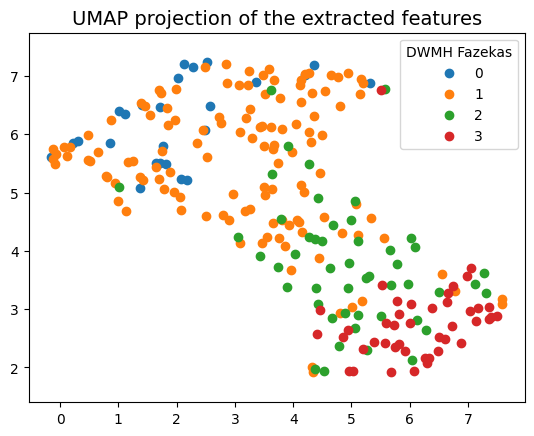

In [255]:
labels = dy
labels = dinfo['DWMH'].values
types = torch.from_numpy(labels).unique().tolist()
for label in types:
    plt.scatter(
        embedding[:, 0][labels==label],
        embedding[:, 1][labels==label],
        color=sns.color_palette()[int(label)],
        label = int(label))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the extracted features', fontsize=14);
plt.legend(title='DWMH Fazekas')

In [256]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(arr)
X_pca.shape

(243, 2)

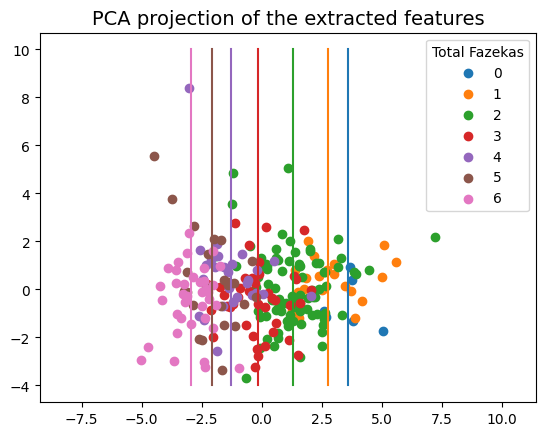

In [257]:
labels = dy
labels = dinfo['total_fazekas'].values
types = torch.from_numpy(labels).unique().tolist()
for label in types:
    x_pos = X_pca[:, 0][labels==label]
    plt.scatter(
        X_pca[:, 0][labels==label],
        X_pca[:, 1][labels==label],
        color=sns.color_palette()[int(label)],
        label = int(label))
    plt.plot([x_pos.mean(), x_pos.mean()], [-4, 10], color=sns.color_palette()[int(label)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection of the extracted features', fontsize=14);
plt.legend(title='Total Fazekas')

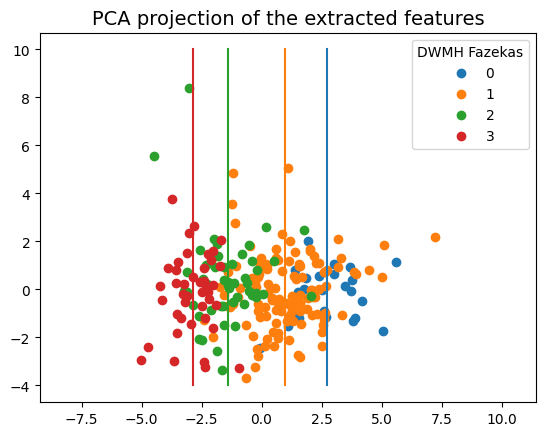

In [258]:
labels = dy
labels = dinfo['DWMH'].values
types = torch.from_numpy(labels).unique().tolist()
for label in types:
    x_pos = X_pca[:, 0][labels==label]
    plt.scatter(
        X_pca[:, 0][labels==label],
        X_pca[:, 1][labels==label],
        color=sns.color_palette()[int(label)],
        label = int(label))
    plt.plot([x_pos.mean(), x_pos.mean()], [-4, 10], color=sns.color_palette()[int(label)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection of the extracted features', fontsize=14);
plt.legend(title='DWMH Fazekas')

In [294]:
pca.explained_variance_.sum()

7.414755778838176

In [203]:
indexes = torch.from_numpy(dinfo['WMH'].values).sort()[1]

In [204]:
data = arr[indexes]

norm_data = data / data.norm(dim=1, keepdim=True)

# Compute the cosine similarity matrix
cosine_similarity_matrix = torch.mm(norm_data, norm_data.t())

# Convert to numpy for visualization
cosine_similarity_matrix_np = cosine_similarity_matrix.numpy()

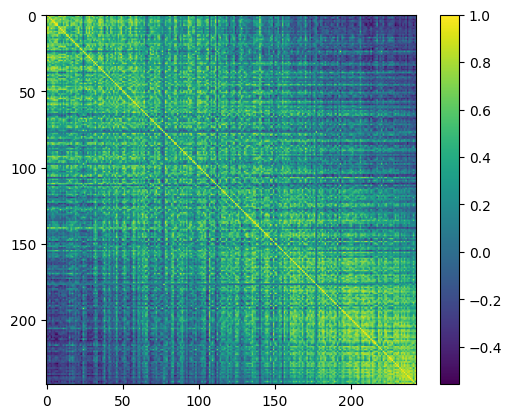

In [206]:
plt.imshow(cosine_similarity_matrix_np)
plt.colorbar()

In [92]:
arr.unfold(1, 1, 1).shape

torch.Size([243, 25, 1])

In [87]:

cosine_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-08)

In [90]:
cs = cosine_sim(arr, arr)

torch.Size([243])

In [175]:

thresholdsv1 = {
    "ent1_t":0.5,"ent2_t":0.3,"ent3_t":0.3,"pred1_t":0.3,"pred2_t":0.1,"pred3_t":0.1
}
ct1 = 0.75 # for PVWMH

thresholdsv2 = {
    "ent1_t":0.4,"ent2_t":0.4,"ent3_t":0.3,"pred1_t":0.6,"pred2_t":0.1,"pred3_t":0.5
}
ct2 = 0.8 # for DWMH

model_types = ["clinical_only","c+volume","cv_samples", "cv_pred", "cv_umap","cvps+umap"]

# model_types = ["cvpsu+hists"]

log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

S = 12

clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                         random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False,
                         n_jobs=None, l1_ratio=None)

results_pvwmh = {}

for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv1, colinear_threshold=ct1, n_splits=S,
                                 val_proportion=0.0, target="PVWMH", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    results_pvwmh[model_type] = results

Index(['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia',
       'smoking_0', 'smoking_1', 'smoking_2'],
      dtype='object')
clinical_only, 0.32, 0.39
Index(['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia',
       'smoking_0', 'smoking_1', 'smoking_2', 'pred0.5_seg_volume',
       'pred0.5_vent_volume'],
      dtype='object')
c+volume, 0.57, 0.61
Index(['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia',
       'smoking_0', 'smoking_1', 'smoking_2', 'pred0.5_seg_volume',
       'pred0.5_vent_volume', 'sample_div_skew', 'sample_div_vd_std'],
      dtype='object')
cv_samples, 0.6, 0.62
Index(['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia',
       'smoking_0', 'smoking_1', 'smoking_2', 'pred0.5_seg_volume',
       'pred0.5_vent_volume', 'pred0.3_cc_num', 'pred0.3_cc_size_mean',
       'pred0.1_cc_vd_mean', 'pred0.1_cc_vd_skew', 'pred0.1_std',
       'pred0.1_prop_seg_uncertain', 'pred0.1_dist_mean', 'pred0.1_dist_skew'],
      dtype='object')


<Figure size 1000x1000 with 0 Axes>

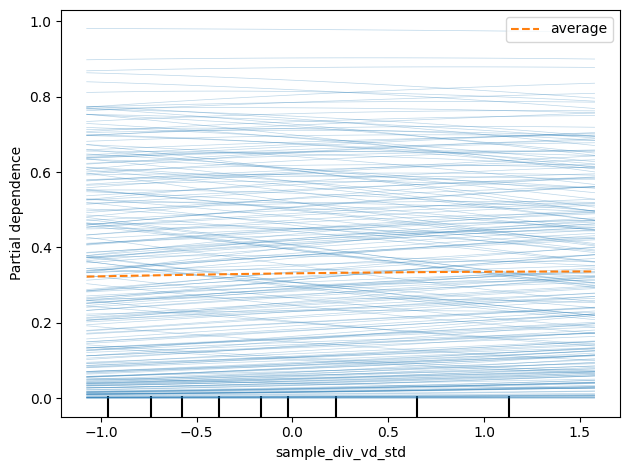

In [288]:
from sklearn.inspection import PartialDependenceDisplay
plt.figure(figsize=(10, 10))
PartialDependenceDisplay.from_estimator(clf, dX, ['sample_div_vd_std'], kind='both', target=1)
plt.tight_layout()

In [313]:
fd = full_combined_df.copy()

rescaler = Rescaler()
rescaler.fit(fd)
fd = rescaler.predict(fd)

fd = fd.drop(columns=target_fields)
fd = fd.dropna(axis=1)

In [314]:
fd

,sbjGroup,age,sex,diabetes,hypertension,smoking_0,smoking_1,smoking_2,sample_div_std,sample_div_IQR,...,ent0.5_values_hist_10,ent0.5_values_hist_11,ent0.5_values_hist_12,ent0.5_values_hist_13,ent0.5_values_hist_14,ent0.5_values_hist_15,ent0.5_values_hist_16,ent0.5_values_hist_17,ent0.5_values_hist_18,ent0.5_values_hist_19
0,0.254355,-0.208694,2,0,1,1.0,0.0,0.0,-0.568432,-0.441561,...,1.874150,-0.129559,0.372367,-0.229365,-0.308072,-2.081278,0.552356,-0.056328,1.576035,0.0
1,0.254355,0.920000,1,0,0,1.0,0.0,0.0,-0.484626,-0.368287,...,-1.207256,-0.665606,-0.970214,0.290494,-0.667354,0.187889,-0.161589,0.686474,0.944336,0.0
2,0.254355,0.051774,1,0,1,0.0,0.0,1.0,0.952006,1.100536,...,-0.207764,0.108652,0.517009,0.625599,0.220881,1.068963,0.364748,1.262937,0.747412,0.0
3,0.254355,-0.208694,1,0,1,0.0,0.0,1.0,0.696339,0.921384,...,-0.082444,-0.100325,0.660801,-0.836665,-0.197174,0.975968,1.077604,0.807038,0.380169,0.0
4,0.254355,1.093645,1,0,0,0.0,1.0,0.0,-0.054126,-0.250698,...,0.776915,0.373818,0.488478,0.027055,-0.275726,-0.921960,-0.915500,-0.228562,-0.815612,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,0.254355,-1.337388,1,0,1,0.0,0.0,1.0,-1.080462,-1.059255,...,1.200940,2.511424,1.189792,-2.092187,1.011861,-0.827783,-3.540867,-2.159284,-2.089390,0.0
244,0.254355,-1.771501,1,0,0,0.0,0.0,1.0,-0.252268,-0.214931,...,0.063364,0.427928,0.695353,0.345279,2.608031,-0.584915,-1.091150,-0.997299,-0.190090,0.0
245,0.254355,-1.250566,1,0,0,0.0,0.0,1.0,-0.836801,-0.910331,...,0.816513,0.101323,-3.289514,-1.753570,-2.256485,0.561251,-1.166367,-1.208816,-2.097096,0.0
246,0.254355,0.659532,1,0,1,0.0,0.0,1.0,-0.378292,-0.510405,...,-0.602750,-0.825248,-0.268774,0.186791,-0.536235,1.301439,-0.589306,-0.237701,-1.179309,0.0


In [315]:
idxs = []
expls = []
for i in range(1070):
    pca2 = PCA(n_components=i+1)
    pca2.fit(fd)
    idxs.append(i)
    expls.append(pca2.explained_variance_.sum())

ValueError: n_components=249 must be between 0 and min(n_samples, n_features)=248 with svd_solver='full'

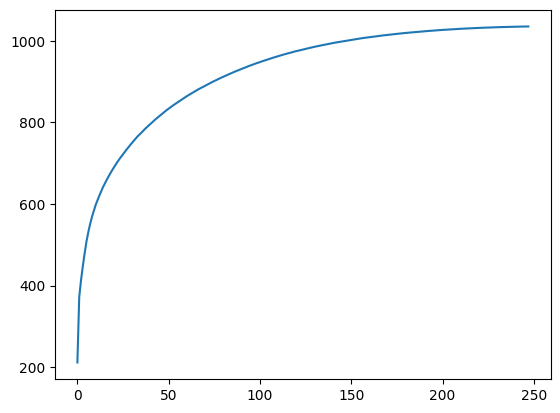

In [316]:
plt.plot(idxs, expls)

In [264]:
clf.classes_

array([0., 1., 2., 3.])

In [263]:
merged_d.keys()

Index(['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia',
       'smoking_0', 'smoking_1', 'smoking_2', 'pred0.5_seg_volume',
       'pred0.5_vent_volume', 'pred0.3_cc_num', 'pred0.3_cc_size_mean',
       'pred0.1_cc_vd_mean', 'pred0.1_cc_vd_skew', 'pred0.1_std',
       'pred0.1_prop_seg_uncertain', 'pred0.1_dist_mean', 'pred0.1_dist_skew',
       'sample_div_skew', 'sample_div_vd_std', 'ent0.5_cc_size_mean',
       'ent0.3_mean', 'ent0.3_std', 'target'],
      dtype='object')

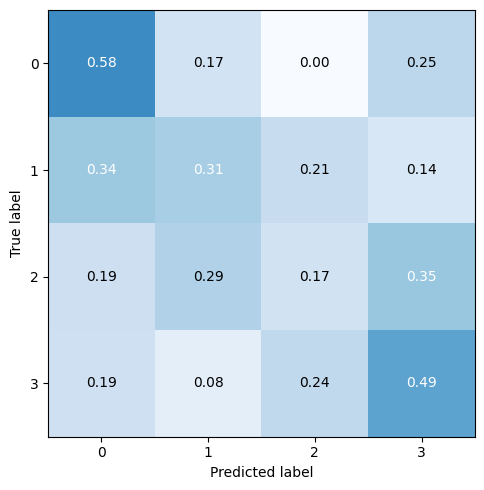

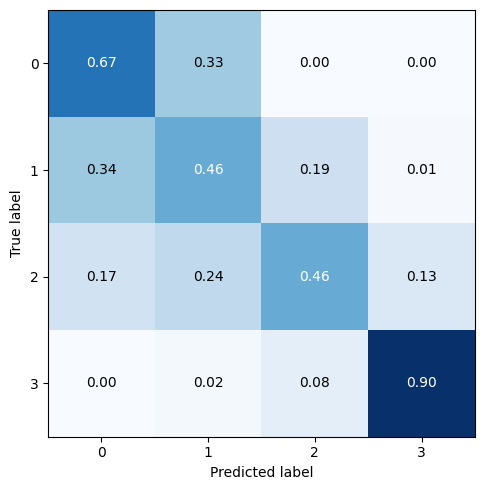

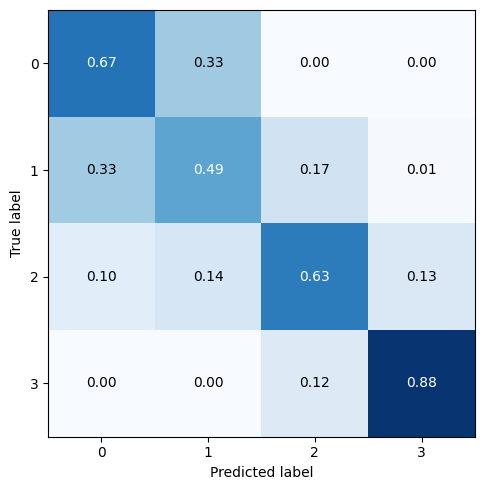

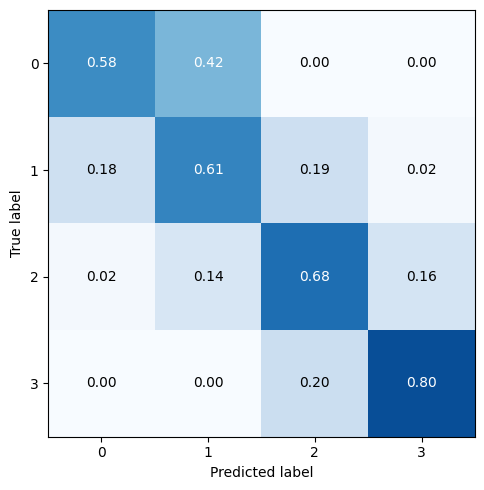

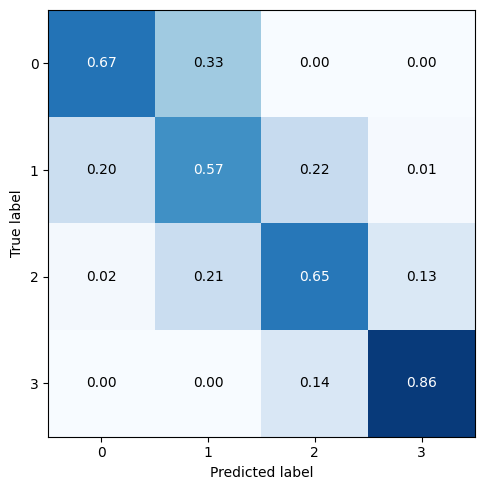

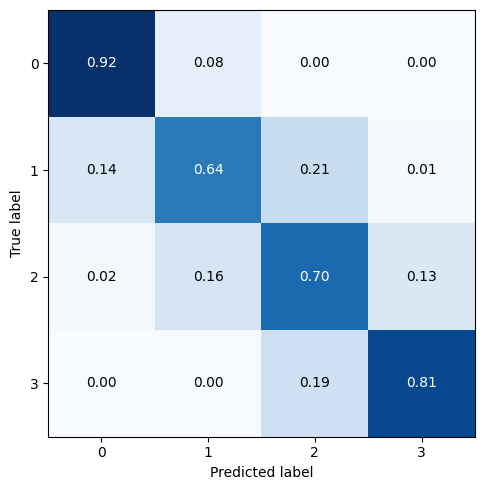

In [70]:
for m in model_types:
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(results_pvwmh[m][2], results_pvwmh[m][3], fig, ax)
    plt.savefig(f"confusion_matrices_CVD/{uncertainty_type}: {m}: full_cfields PVWMH fazekas prediction on ADNI")

In [71]:
results_pvwmh = {}

for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv1, colinear_threshold=ct1, n_splits=S,
                                 val_proportion=0.0, target="PVWMH", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=True)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    results_pvwmh[model_type] = results

clinical_only, 0.32, 0.41
c+volume, 0.52, 0.58
cv_samples, 0.59, 0.63
cv_pred, 0.65, 0.68
cv_umap, 0.64, 0.68
cvps+umap, 0.67, 0.72


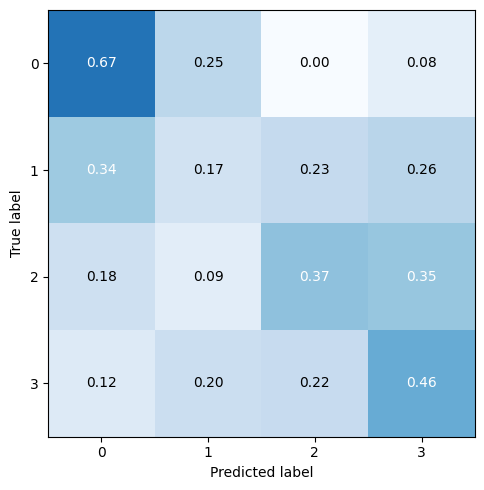

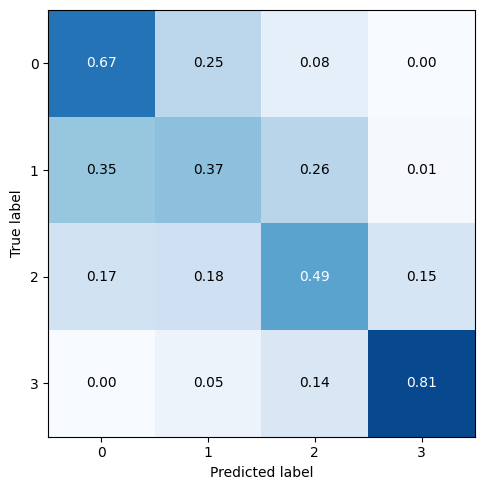

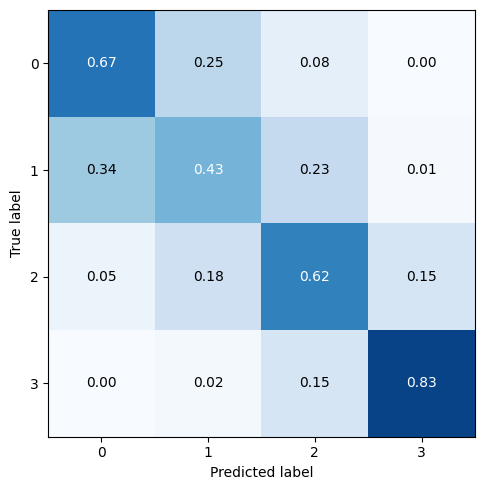

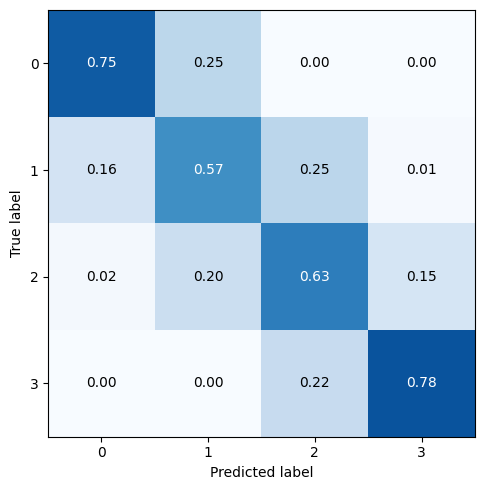

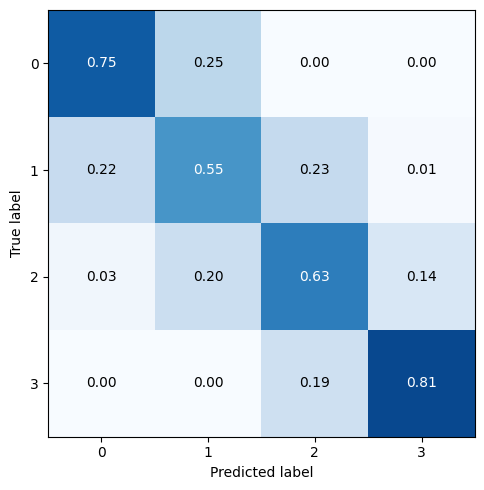

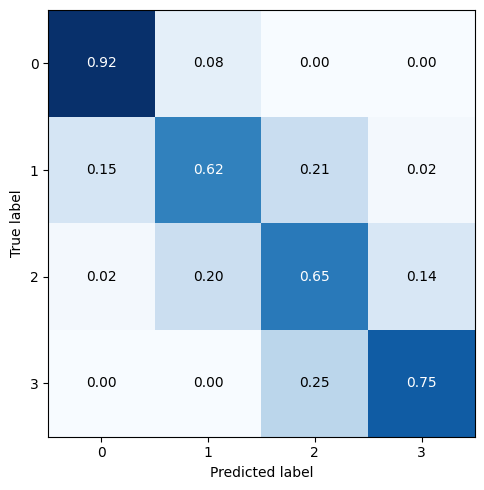

In [72]:
for m in model_types:
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(results_pvwmh[m][2], results_pvwmh[m][3], fig, ax)
    plt.savefig(f"confusion_matrices_CVD/{uncertainty_type}: {m}: limited_cfields PVWMH fazekas prediction on ADNI")

In [76]:
# clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#                          random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model_type = "cvs_umap"

# log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

# configs = []
# for ent1 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#     for ent2 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#         for ent3 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#             for thresh in [0.6, 0.7, 0.8, 0.9]:
#                 configs.append((f"e1:{ent1}_e2:{ent2}_e3:{ent3}_thresh:{thresh}", ent1, ent2, ent3, thresh))

# S = 12
# cv_results_ent = {}
# for (config_name, ent1, ent2, ent3, thresh) in configs:
#     thresholds = {
#         "ent1_t":ent1,"ent2_t":ent2,"ent3_t":ent3
#     }
#     results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="DWMH", stratify_target=None, 
#                    rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
#                    rem_colinear_feats=True, colinear_threshold=thresh, colinear_ignores=target_fields, regression=False)
#     print(f"{config_name}, {results[0]:.2}, {results[1]:.2}")
#     cv_results_ent[config_name] = [results[0], results[1]]

In [69]:
print("len: ", len(cv_results_ent.keys()))
for key in cv_results_ent:
    cv_results_ent[key] = torch.stack(cv_results_ent[key])

df_results_ent = pd.DataFrame(cv_results_ent)
df_results_ent.loc[0].argmax(), df_results_ent.loc[1].argmax()

len:  864


(513, 513)

In [70]:
df_results_ent.loc[0].keys()[513], df_results_ent.loc[0].keys()[513], df_results_ent.loc[1].values[513], df_results_ent.loc[1].values[513]

('e1:0.4_e2:0.4_e3:0.3_thresh:0.7',
 'e1:0.4_e2:0.4_e3:0.3_thresh:0.7',
 0.6452725,
 0.6452725)

In [77]:
# clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#                          random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model_type = "cv_pred"

# log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

# configs = []
# for pred1 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#     for pred2 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#         for pred3 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#             for thresh in [0.6, 0.7, 0.8, 0.9]:
#                 configs.append((f"p1:{pred1}_p2:{pred2}_p3:{pred3}_thresh:{thresh}", pred1, pred2, pred3, thresh))

# S = 12
# cv_results_pred = {}
# for (config_name, pred1, pred2, pred3, thresh) in configs:
#     thresholds = {
#         "pred1_t":pred1,"pred2_t":pred2,"pred3_t":pred3
#     }
#     results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="DWMH", stratify_target=None, 
#                    rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
#                    rem_colinear_feats=True, colinear_threshold=thresh, colinear_ignores=target_fields, regression=False)
#     print(f"{config_name}, {results[0]:.2}, {results[1]:.2}")
#     cv_results_pred[config_name] = [results[0], results[1]]

In [74]:
print("len: ", len(cv_results_pred.keys()))
for key in cv_results_pred:
    cv_results_pred[key] = torch.stack(cv_results_pred[key])

df_results_pred = pd.DataFrame(cv_results_pred)
df_results_pred.loc[0].argmax(), df_results_pred.loc[1].argmax()

(739, 739)

In [75]:
df_results_pred.loc[0].keys()[739], df_results_pred.loc[1].values[739]

('p1:0.6_p2:0.1_p3:0.5_thresh:0.9', 0.7072916)

In [64]:
uncertainty_type

In [79]:
results_dwmh08 = {}
S = 7
for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv2, colinear_threshold=ct2, n_splits=S, val_proportion=0.0, target="DWMH", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    results_dwmh08[model_type] = results


clinical_only, 0.31, 0.33
c+volume, 0.49, 0.51
cv_samples, 0.51, 0.53
cv_pred, 0.64, 0.67
cv_umap, 0.67, 0.71
cvps+umap, 0.68, 0.71


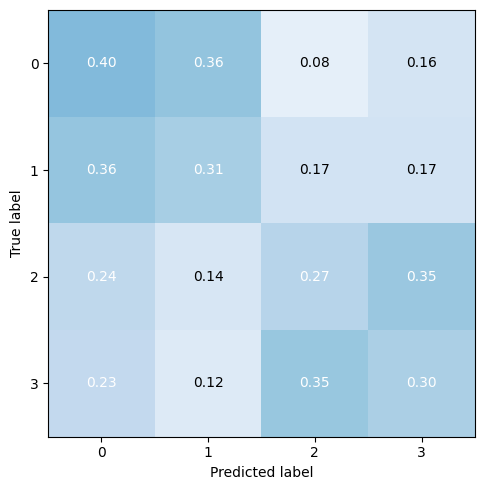

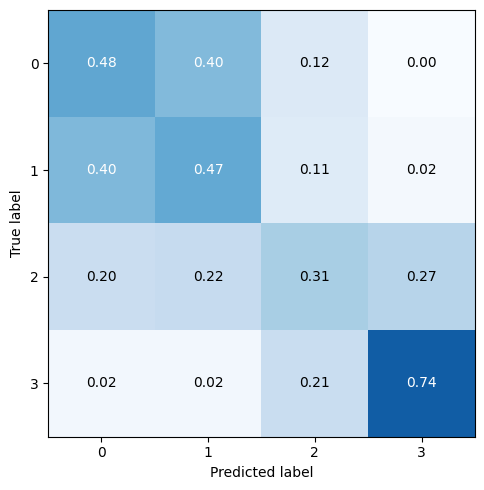

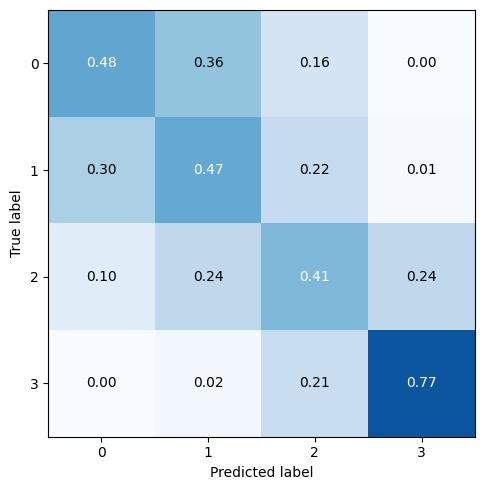

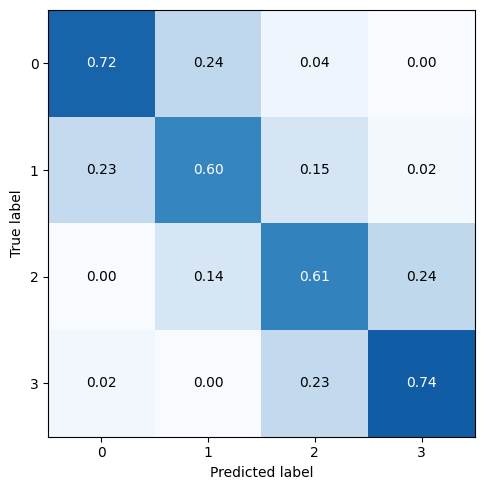

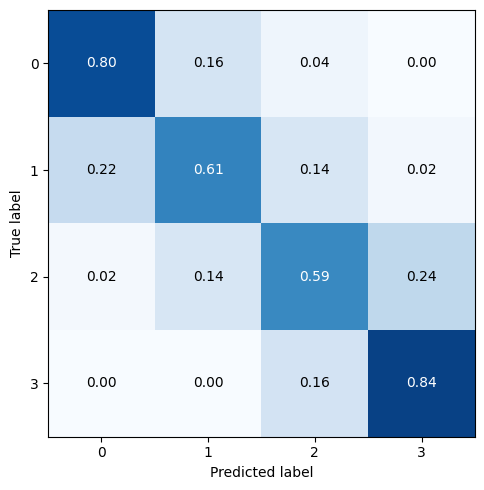

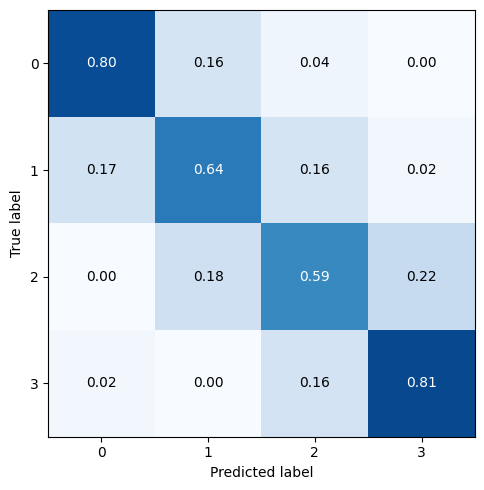

In [80]:
for m in model_types:
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(results_dwmh08[m][2], results_dwmh08[m][3], fig, ax)
    plt.savefig(f"confusion_matrices_CVD/{uncertainty_type}: {m}: full_cfields DWMH fazekas prediction on ADNI")

In [81]:
results_dwmh08 = {}
S = 7
for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv2, colinear_threshold=ct2, n_splits=S, val_proportion=0.0, target="DWMH", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=True)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    results_dwmh08[model_type] = results

clinical_only, 0.24, 0.32
c+volume, 0.53, 0.57
cv_samples, 0.49, 0.54
cv_pred, 0.65, 0.7
cv_umap, 0.66, 0.71
cvps+umap, 0.68, 0.72


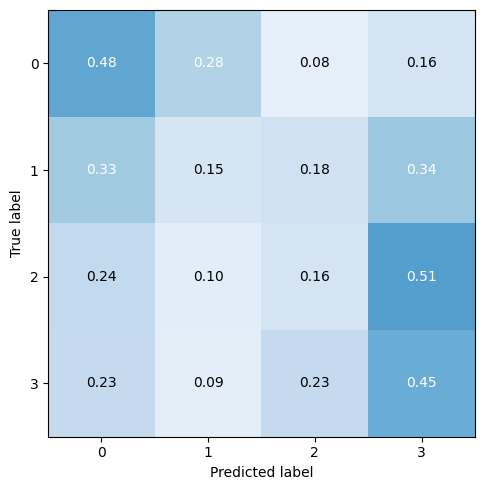

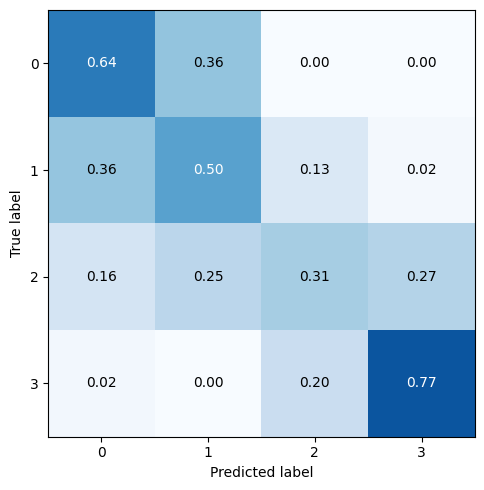

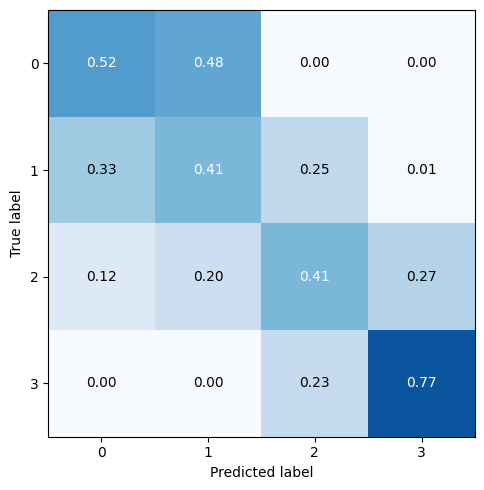

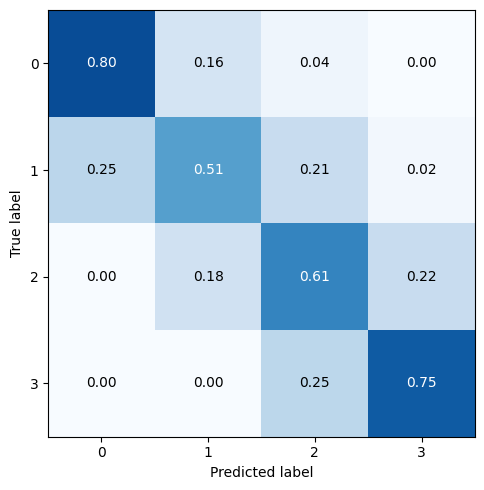

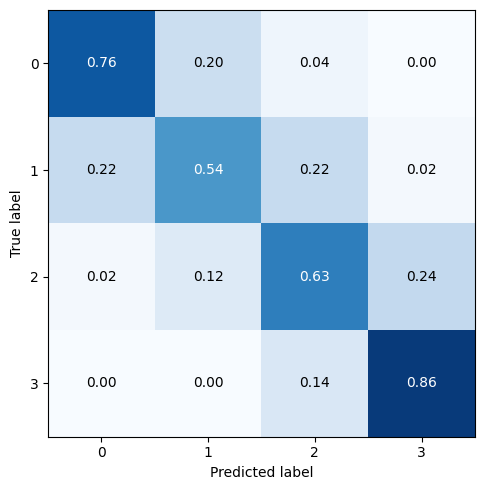

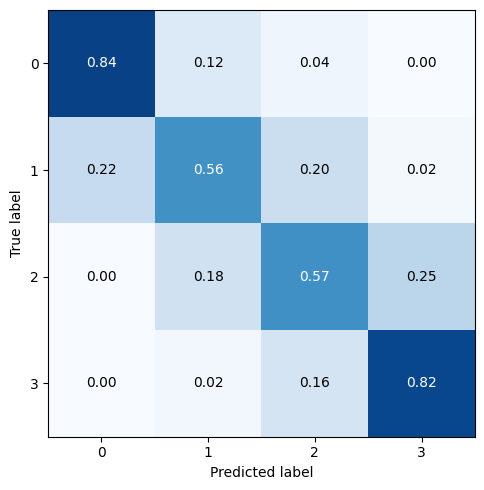

In [77]:
for m in model_types:
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(results_dwmh08[m][2], results_dwmh08[m][3], fig, ax)
    plt.savefig(f"confusion_matrices_CVD/{uncertainty_type}: {m}: limited_cfields DWMH fazekas prediction on ADNI")

### Quality control via dice prediction

okay the task that needs doing is the following:
do all of the methods on the dice scores for the deterministic model
store the predictions for each model


In [86]:
def regression_task(target):

    S = 12

    # clf_reg = BayesianRidge()
    clf_reg = LinearRegression()
    
    all_results = {}

    for model_type in model_types:
        results = run_prediction_new(full_combined_df, model_type, clf=clf_reg, thresholds_dict=thresholdsv1, colinear_threshold=ct1, n_splits=S, val_proportion=0.0, target=target, stratify_target="DWMH", 
                       rescale=True, predict_val=False, verbose=False, metric='rmse', do_log=False, log_feature_matches=log_feature_matches, 
                       rem_colinear_feats=True, colinear_ignores=target_fields, regression=True)
        all_results[model_type] = results
        print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    
    return all_results

In [88]:
dice_results = regression_task("deterministic_dice")

clinical_only, 0.14, 0.14
c+volume, 0.11, 0.11
cv_samples, 0.09, 0.09
cv_pred, 0.076, 0.076
cv_umap, 0.081, 0.081
cvps+umap, 0.073, 0.073



###
method:  clinical_only dice_thresh:  0.45
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 4, 7, 9, 9, 12, 17, 21, 28, 31, 37, 41, 47, 57, 69, 78, 89, 103, 117, 133, 152, 173, 187, 196, 207, 218, 220, 222, 224, 226, 231, 234, 236, 239, 240, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243]

ys =  [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 27, 26, 26, 26, 25, 24, 24, 23, 22, 19, 19, 17, 15, 13, 12, 12, 11, 10, 8, 4, 3, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys)
tensor(29)

###
method:  cv_samples dice_thresh:  0.45
xs =  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 

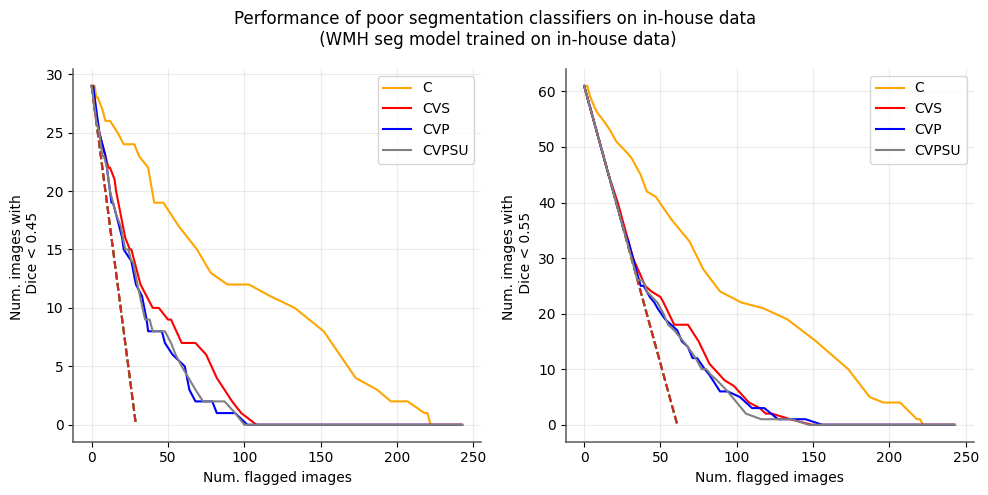

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

name_key = {'clinical_only':'C', 'cv_samples':'CVS', 'cv_pred':'CVP', 'cvps+umap':'CVPSU'}
colour_key = {'clinical_only':'orange', 'cv_samples':'red', 'cv_pred':'blue', 'cvps+umap':'grey'}

for ax, dice_thresh in zip(axs.flatten(), [0.45, 0.55]):
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=0)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=0)
    
    for method in ['clinical_only', 'cv_samples', 'cv_pred', 'cvps+umap']:
        # method = 'clinical_only'
        target = dice_results[method][2]
        pred = dice_results[method][3]

        bad_images = target < dice_thresh
        num_bad_images = bad_images.sum()

        ax.plot([0, num_bad_images], [num_bad_images, 0], linestyle='dashed')

        thresholds = torch.arange(0, 1, 0.01)

        xs = []
        ys = []

        for t in thresholds:
            flagged_images = pred < t
            num_flagged_images = flagged_images.sum()
            remaining_bad_images = bad_images * (torch.logical_not(flagged_images))
            num_remaining_bad_images = remaining_bad_images.sum()

            ys.append(num_remaining_bad_images)
            xs.append(num_flagged_images)

        ax.plot(xs, ys, label=name_key[method], c=colour_key[method])
        ax.set_ylabel(f"Num. images with \n Dice < {dice_thresh}")
        ax.set_xlabel("Num. flagged images")
        ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
        ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
        ax.spines[['left', 'bottom']].set_color('#585858')
        
        print("\n###")
        print("method: ", method, "dice_thresh: ", dice_thresh)
        print("xs = ", torch.stack(xs).tolist())
        print("")
        print("ys = ", torch.stack(ys).tolist())
        print("plt.plot(xs, ys)")
        print(num_bad_images)
    ax.legend()
    
    
    
plt.suptitle("Performance of poor segmentation classifiers on in-house data\n (WMH seg model trained on in-house data)")
fig.tight_layout()

plt.savefig("qual_control_CVD.pdf")

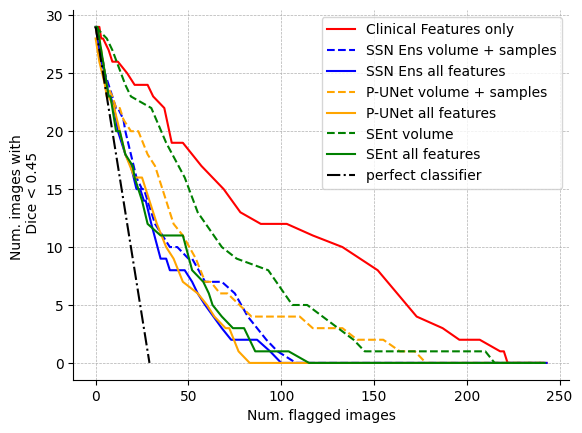

In [135]:
### SSN ENS
# clinical
# method:  clinical_only dice_thresh:  0.45
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 4, 7, 9, 9, 12, 17, 21, 28, 31, 37, 41, 47, 57, 69, 78, 89, 103, 117, 133, 152, 173, 187, 196, 207, 218, 220, 222, 224, 226, 231, 234, 236, 239, 240, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243]

ys =  [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 27, 26, 26, 26, 25, 24, 24, 23, 22, 19, 19, 17, 15, 13, 12, 12, 11, 10, 8, 4, 3, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, label="Clinical Features only", c='red')

# method:  cv_samples dice_thresh:  0.45
xs =  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 5, 7, 11, 11, 12, 15, 16, 22, 25, 26, 28, 32, 40, 44, 50, 52, 59, 68, 75, 82, 92, 98, 108, 115, 119, 123, 135, 149, 154, 160, 171, 177, 183, 189, 198, 203, 209, 217, 219, 222, 222, 224, 228, 229, 229, 233, 236, 237, 238, 238, 238, 239, 240, 240, 240, 240, 240, 240, 242]

ys =  [28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 27, 27, 27, 27, 26, 26, 26, 26, 25, 24, 22, 22, 22, 21, 20, 16, 15, 15, 14, 12, 10, 10, 9, 9, 7, 7, 6, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, '--', label="SSN Ens volume + samples", c='blue')

### best ssn ens
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 5, 6, 6, 7, 8, 8, 8, 10, 12, 14, 16, 19, 22, 24, 26, 27, 30, 35, 37, 38, 40, 41, 48, 52, 55, 59, 68, 73, 77, 80, 83, 87, 94, 100, 106, 116, 120, 127, 136, 147, 157, 167, 173, 181, 188, 196, 200, 207, 213, 218, 223, 229, 232, 233, 233, 234, 236, 237, 237, 237, 237, 237, 238, 239, 240, 241, 242, 242, 243]

ys =  [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 27, 27, 26, 25, 24, 24, 23, 23, 23, 23, 22, 20, 19, 18, 17, 15, 15, 14, 14, 12, 9, 9, 9, 8, 8, 8, 7, 6, 5, 3, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, label="SSN Ens all features", c='blue')

### PUNET
###
# method:  cv_samples dice_thresh:  0.45
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 6, 6, 9, 9, 11, 13, 15, 19, 21, 23, 28, 32, 42, 47, 54, 59, 62, 67, 71, 84, 98, 104, 110, 117, 124, 133, 141, 155, 164, 172, 178, 179, 186, 190, 192, 201, 207, 210, 214, 215, 221, 226, 229, 229, 233, 235, 235, 236, 238, 238, 240, 240, 240, 240, 240, 241, 241, 241, 242]

ys =  [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 27, 26, 26, 26, 24, 24, 23, 23, 22, 22, 21, 20, 20, 20, 18, 17, 12, 11, 9, 7, 7, 6, 6, 4, 4, 4, 4, 3, 3, 3, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, '--', label="P-UNet volume + samples", c='orange')
# tensor(29)

###
# method:  cvps+umap dice_thresh:  0.45
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 5, 5, 6, 7, 7, 7, 7, 10, 13, 16, 21, 23, 25, 31, 33, 38, 42, 47, 55, 60, 64, 70, 72, 77, 83, 87, 93, 97, 104, 109, 113, 117, 124, 134, 138, 143, 152, 159, 164, 167, 174, 184, 191, 198, 204, 209, 214, 217, 219, 222, 227, 229, 231, 232, 235, 238, 239, 239, 240, 240, 240, 240, 240, 241, 241]

ys =  [28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 27, 27, 27, 26, 24, 24, 24, 23, 23, 23, 23, 23, 22, 20, 18, 16, 16, 16, 13, 12, 10, 9, 7, 6, 5, 4, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, label="P-UNet all features", c='orange')
# tensor(28)

## DETERMINISTIC
# method:  cv_samples dice_thresh:  0.45
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 16, 19, 30, 38, 48, 55, 68, 76, 93, 106, 114, 139, 145, 156, 161, 167, 177, 182, 187, 192, 196, 197, 201, 206, 210, 215, 217, 220, 221, 222, 225, 227, 231, 233, 233, 234, 236, 236, 236, 236, 236, 237, 237, 239, 239, 239, 239, 240]

ys =  [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 27, 24, 23, 22, 19, 16, 13, 10, 9, 8, 5, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, '--', label="SEnt volume", c='green')
# tensor(29)

###
# method:  cvps+umap dice_thresh:  0.45
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 7, 7, 7, 7, 8, 10, 11, 13, 16, 20, 20, 21, 25, 28, 35, 36, 40, 42, 47, 52, 58, 61, 63, 68, 74, 80, 86, 92, 98, 100, 104, 115, 123, 129, 135, 139, 148, 155, 165, 179, 180, 185, 189, 192, 202, 206, 214, 218, 220, 225, 227, 232, 233, 234, 236, 238, 240, 240, 240, 241, 241, 241, 241, 241, 241, 242]

ys =  [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 27, 27, 26, 25, 23, 23, 23, 23, 23, 21, 20, 20, 18, 17, 17, 16, 14, 12, 11, 11, 11, 11, 11, 8, 7, 6, 5, 4, 3, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, label="SEnt all features", c='green')
# tensor(29)


num_bad_images = 29
plt.plot([0, num_bad_images], [num_bad_images, 0], linestyle='dashdot', color='black', label='perfect classifier')

plt.legend()

plt.grid(axis='both', linestyle='--', linewidth=0.5) 
    
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel(f"Num. images with \n Dice < 0.45")
plt.xlabel("Num. flagged images");

plt.savefig("QC dice 0.45.pdf", bbox_inches="tight")

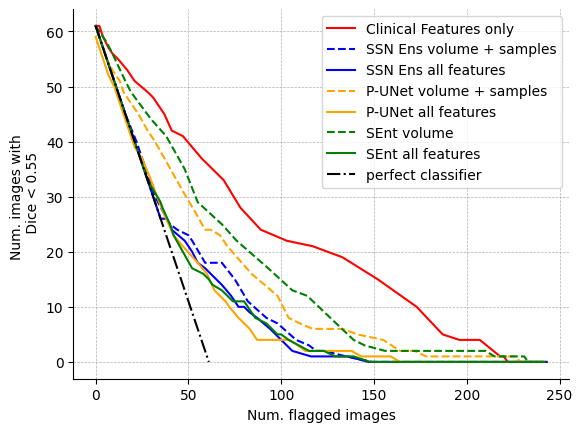

In [136]:

### SSN ENS
# method:  clinical_only dice_thresh:  0.55
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 4, 7, 9, 9, 12, 17, 21, 28, 31, 37, 41, 47, 57, 69, 78, 89, 103, 117, 133, 152, 173, 187, 196, 207, 218, 220, 222, 224, 226, 231, 234, 236, 239, 240, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243]

ys =  [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 60, 59, 57, 56, 56, 55, 53, 51, 49, 48, 45, 42, 41, 37, 33, 28, 24, 22, 21, 19, 15, 10, 5, 4, 4, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, label="Clinical Features only", c='red')

###
# method:  cv_samples dice_thresh:  0.55
xs =  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 5, 7, 11, 11, 12, 15, 16, 22, 25, 26, 28, 32, 40, 44, 50, 52, 59, 68, 75, 82, 92, 98, 108, 115, 119, 123, 135, 149, 154, 160, 171, 177, 183, 189, 198, 203, 209, 217, 219, 222, 222, 224, 228, 229, 229, 233, 236, 237, 238, 238, 238, 239, 240, 240, 240, 240, 240, 240, 242]

ys =  [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 59, 59, 59, 59, 59, 59, 59, 59, 59, 58, 58, 57, 57, 56, 54, 50, 50, 49, 46, 45, 40, 37, 36, 34, 30, 25, 24, 23, 22, 18, 18, 15, 11, 8, 7, 4, 3, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, '--', label="SSN Ens volume + samples", c='blue')


###
# method:  cvps+umap dice_thresh:  0.55
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 5, 6, 6, 7, 8, 8, 8, 10, 12, 14, 16, 19, 22, 24, 26, 27, 30, 35, 37, 38, 40, 41, 48, 52, 55, 59, 68, 73, 77, 80, 83, 87, 94, 100, 106, 116, 120, 127, 136, 147, 157, 167, 173, 181, 188, 196, 200, 207, 213, 218, 223, 229, 232, 233, 233, 234, 236, 237, 237, 237, 237, 237, 238, 239, 240, 241, 242, 242, 243]

ys =  [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 59, 59, 58, 56, 55, 55, 54, 53, 53, 53, 51, 49, 47, 45, 42, 39, 37, 35, 34, 31, 26, 26, 26, 25, 24, 22, 20, 18, 17, 14, 12, 10, 10, 9, 8, 6, 4, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, label="SSN Ens all features", c='blue')

### PUNET
# method:  cv_samples dice_thresh:  0.55
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 6, 6, 9, 9, 11, 13, 15, 19, 21, 23, 28, 32, 42, 47, 54, 59, 62, 67, 71, 84, 98, 104, 110, 117, 124, 133, 141, 155, 164, 172, 178, 179, 186, 190, 192, 201, 207, 210, 214, 215, 221, 226, 229, 229, 233, 235, 235, 236, 238, 238, 240, 240, 240, 240, 240, 241, 241, 241, 242]

ys =  [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 60, 60, 59, 59, 59, 59, 59, 59, 59, 59, 58, 57, 57, 57, 55, 55, 53, 53, 52, 51, 49, 47, 46, 45, 42, 40, 34, 31, 27, 24, 24, 23, 21, 16, 12, 8, 7, 6, 6, 6, 5, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, '--', label="P-UNet volume + samples", c='orange')
# tensor(61)

###
# method:  cvps+umap dice_thresh:  0.55
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 5, 5, 6, 7, 7, 7, 7, 10, 13, 16, 21, 23, 25, 31, 33, 38, 42, 47, 55, 60, 64, 70, 72, 77, 83, 87, 93, 97, 104, 109, 113, 117, 124, 134, 138, 143, 152, 159, 164, 167, 174, 184, 191, 198, 204, 209, 214, 217, 219, 222, 227, 229, 231, 232, 235, 238, 239, 239, 240, 240, 240, 240, 240, 241, 241]

ys =  [59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 58, 58, 58, 58, 58, 58, 58, 58, 57, 54, 54, 54, 53, 52, 52, 52, 52, 50, 47, 44, 39, 38, 37, 32, 30, 26, 23, 21, 18, 16, 13, 11, 10, 8, 6, 4, 4, 4, 4, 3, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, label="P-UNet all features", c='orange')
# tensor(59)

###
# method:  cv_samples dice_thresh:  0.55
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 16, 19, 30, 38, 48, 55, 68, 76, 93, 106, 114, 139, 145, 156, 161, 167, 177, 182, 187, 192, 196, 197, 201, 206, 210, 215, 217, 220, 221, 222, 225, 227, 231, 233, 233, 234, 236, 236, 236, 236, 236, 237, 237, 239, 239, 239, 239, 240]

ys =  [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 58, 56, 51, 49, 44, 41, 35, 29, 25, 22, 17, 13, 12, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, '--', label="SEnt volume", c='green')
# tensor(61)

###
# method:  cvps+umap dice_thresh:  0.55
xs =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 5, 7, 7, 7, 7, 8, 10, 11, 13, 16, 20, 20, 21, 25, 28, 35, 36, 40, 42, 47, 52, 58, 61, 63, 68, 74, 80, 86, 92, 98, 100, 104, 115, 123, 129, 135, 139, 148, 155, 165, 179, 180, 185, 189, 192, 202, 206, 214, 218, 220, 225, 227, 232, 233, 234, 236, 238, 240, 240, 240, 241, 241, 241, 241, 241, 241, 242]

ys =  [61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 60, 60, 60, 60, 59, 59, 59, 58, 58, 57, 56, 54, 54, 54, 54, 53, 51, 50, 48, 45, 41, 41, 40, 36, 33, 29, 28, 25, 23, 20, 17, 16, 15, 14, 13, 11, 11, 8, 7, 5, 5, 4, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(xs, ys, label="SEnt all features", c='green')
# tensor(61)

num_bad_images = 61
plt.plot([0, num_bad_images], [num_bad_images, 0], linestyle='dashdot', color='black', label='perfect classifier')
plt.legend()

plt.grid(axis='both', linestyle='--', linewidth=0.5) 
    
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel(f"Num. images with \n Dice < 0.55")
plt.xlabel("Num. flagged images");

plt.savefig("QC dice 0.55.pdf", bbox_inches="tight")

### what to do

- [x] load the deterministic model dice scores.

- [x] do c, cv, cvu compare all methods. Nice.

- [x] print out a list of the values for each method.

- need to recompute the ssn ens results for this notebook for the confusion matrices.

- calculate the rmse on the original target data for quality control. Noice.